In [2]:
# load packages
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from gpflow.utilities import print_summary

gpflow.config.set_default_summary_fmt("notebook")
plt.style.use("seaborn-whitegrid")

In [3]:
# useful functions
def stack_parameters(*parameters):
    return np.column_stack([[*parameters]]).T

def normalise(parameters):
    normalised_parameters = np.zeros_like(parameters)
    normalisation_values = []
    for index, parameter in enumerate(parameters.T):
        shift = - np.min(parameter)
        scale = np.max(parameter + shift)
        normalised_parameters[:,index] = (parameter + shift)/scale
        normalisation_values.append((shift, scale))
        
    return normalised_parameters, normalisation_values
    
def scale(normalised_parameters, normalisation_values):
    parameters = np.zeros_like(normalised_parameters)
    for index, parameter in enumerate(normalised_parameters.T):
        shift, scale = normalisation_values[index]
        parameters[:,index] = (parameter * scale) - shift
        
    return parameters

def coords_flattern(*coords):
    meshs = np.meshgrid(*coords)
    return np.column_stack(([mesh.ravel() for mesh in meshs]))

In [4]:
highstand = np.load("highstand_data.npy")
parameters = np.load('parameter_data.npy')
predict_coords = np.load("predict_points.npy")

In [5]:
# move parameter ranges down to improve results
p1 = parameters[:,0]
p2 = parameters[:,1]
p3 = parameters[:,2]
p4 = parameters[:,3]
parameters = stack_parameters(p1, p2, p3, p4)
highstand = highstand.reshape(-1,1)

parameters_norm, parameters_norm_params = normalise(parameters)
highstand_norm, highstand_norm_params = normalise(highstand)

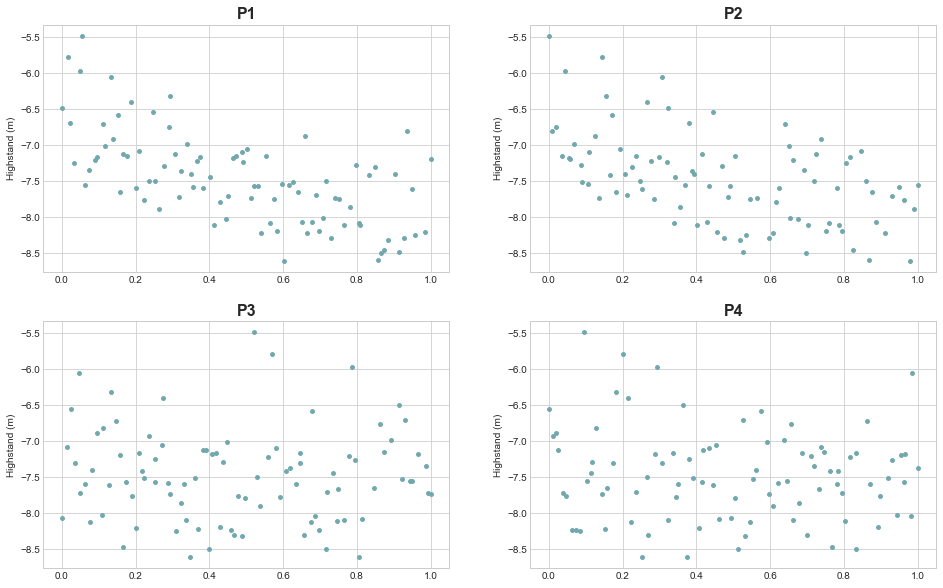

In [6]:
# plot data for parameter
scatter_fig = plt.figure(figsize=[16,10])
for index in range(4):
    ax = scatter_fig.add_subplot(221+index)
    ax.scatter(parameters_norm[:,index], highstand, s=15, c="#71a8ad")
    ax.set_title(f"P{index+1}", fontsize=16, fontweight='bold')
    ax.set_ylabel("Highstand (m)")

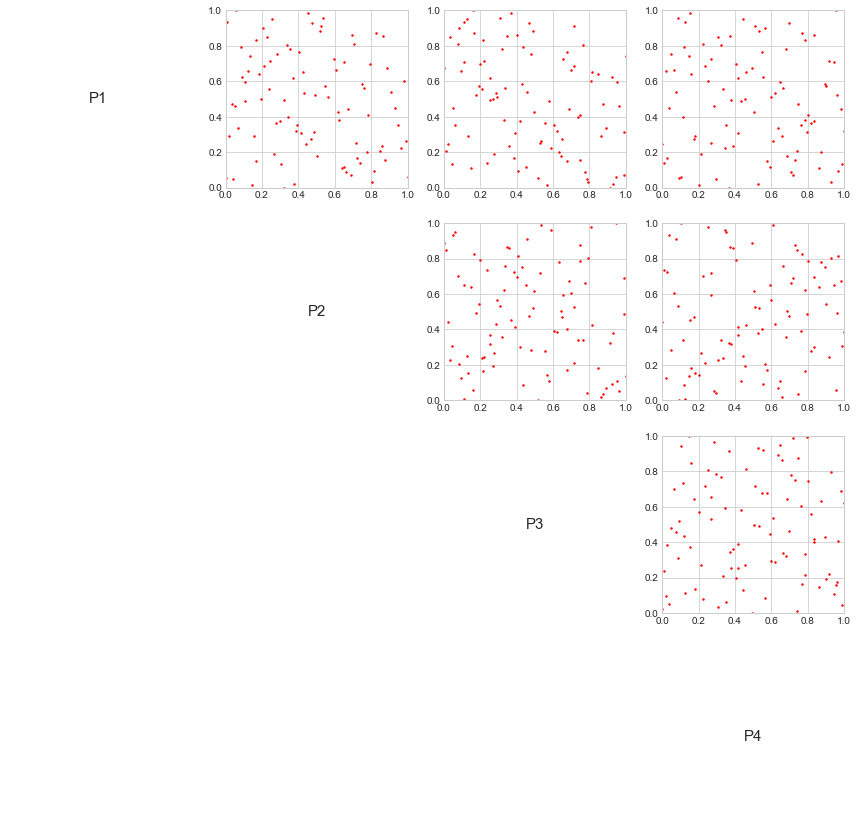

In [7]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15,15))
for index_1 in range(4):
    for index_2 in range(4):
        if index_1 == index_2:
            ax[index_1, index_2].axis('off')
            ax[index_1, index_2].text(0.5,0.5,f"P{index_1+1}",horizontalalignment="center",verticalalignment="center", fontsize=15)
        elif index_2 < index_1:
            ax[index_1, index_2].axis('off')
            
        else:
            ax[index_1, index_2].scatter(parameters_norm[:,index_2], parameters_norm[:,index_1],s=2,c="red")
            ax[index_1, index_2].set_xlim([0,1])
            ax[index_1, index_2].set_ylim([0,1])

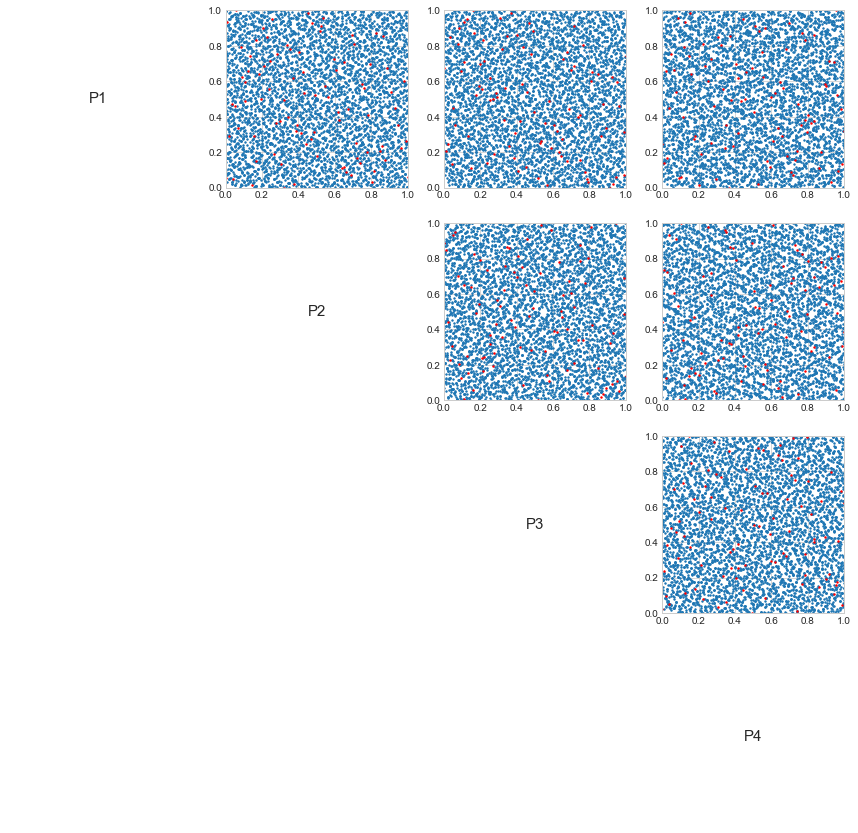

In [8]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15,15))
for index_1 in range(4):
    for index_2 in range(4):
        if index_1 == index_2:
            ax[index_1, index_2].axis('off')
            ax[index_1, index_2].text(0.5,0.5,f"P{index_1+1}",horizontalalignment="center",verticalalignment="center", fontsize=15)
        elif index_2 < index_1:
            ax[index_1, index_2].axis('off')
            
        else:
            ax[index_1, index_2].scatter(predict_coords[:,index_2], predict_coords[:,index_1],s=2,c="C0")
            ax[index_1, index_2].scatter(parameters_norm[:,index_2], parameters_norm[:,index_1],s=2,c="red")
            ax[index_1, index_2].set_xlim([0,1])
            ax[index_1, index_2].set_ylim([0,1])

In [8]:
opt = gpflow.optimizers.Scipy()
k = gpflow.kernels.Matern52(lengthscales=np.ones((len(parameters_norm.T))))
print_summary(k)

name,class,transform,prior,trainable,shape,dtype,value
Matern52.variance,Parameter,Softplus,,True,(),float64,1.0
Matern52.lengthscales,Parameter,Softplus,,True,"(4,)",float64,"[1., 1., 1...."


In [9]:
m = gpflow.models.GPR(data=(parameters_norm, highstand_norm), kernel=k, mean_function=None)
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(4,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


In [10]:
opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,5.585300572883667
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(4,)",float64,"[2.6818737, 3.66118884, 6.05726993..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.012900010603487e-06


In [11]:
mean, var = m.predict_f(np.asarray([[0.2,0.5,0.6,0.7]]))
print(mean.numpy()[0][0], var.numpy()[0][0])

0.45757607196101807 1.079717299568017e-06


In [17]:
mean, var = m.predict_f(predict_coords)
print(mean.numpy()[:,0], var)

[0.26934503 0.2389376  0.40306088 ... 0.18181905 0.45083346 0.67442769] tf.Tensor(
[[3.51001054e-06]
 [1.74842124e-06]
 [6.17603390e-06]
 ...
 [2.20568560e-06]
 [1.28085003e-05]
 [1.02969117e-05]], shape=(6000, 1), dtype=float64)


In [14]:
predict = []
predict_var = []
for index, point in enumerate(parameters_norm):
    parameters_norm_training = np.delete(parameters_norm, index, axis=0)
    highstand_norm_training = np.delete(highstand_norm, index, axis=0)
    
    k = gpflow.kernels.Matern52(lengthscales=np.ones((len(parameters.T))))
    m = gpflow.models.GPR(data=(parameters_norm_training, highstand_norm_training), kernel=k, mean_function=None)
    opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))
    
    lop = parameters_norm[index]
    mean, var = m.predict_f(coords_flattern([lop[0]],[lop[1]],[lop[2]],[lop[3]]))
    predict_var.append(var.numpy()[0][0])
    predict.append(mean.numpy()[0][0])

Text(0.5, 0, 'Actual Highstand Normalised')

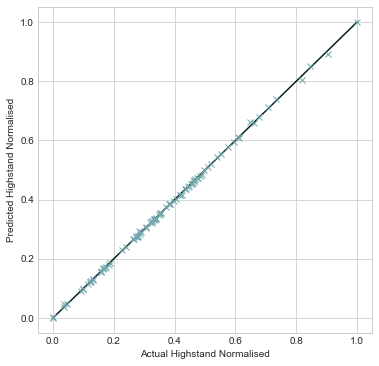

In [15]:
fig, ax = plt.subplots(figsize=[6,6])
ax.plot(np.linspace(0,1,num=100), np.linspace(0,1,num=100), c="#031f1d")
ax.plot(highstand_norm, predict, 'x', c="#71a8ad")
ax.errorbar(highstand_norm, predict, yerr=predict_var, linestyle="None")
ax.set_ylabel("Predicted Highstand Normalised")
ax.set_xlabel("Actual Highstand Normalised")

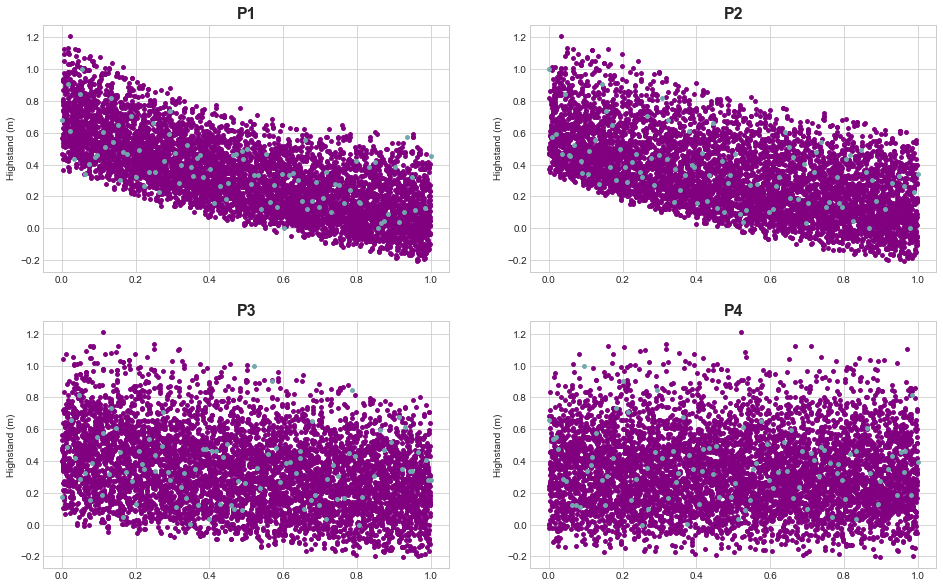

In [20]:
# plot data for parameter
scatter_fig = plt.figure(figsize=[16,10])
for index in range(4):
    ax = scatter_fig.add_subplot(221+index)
    ax.scatter(predict_coords[:,index], mean.numpy()[:,0], s=15, c="purple")
    ax.scatter(parameters_norm[:,index], highstand_norm, s=15, c="#71a8ad")
    ax.set_title(f"P{index+1}", fontsize=16, fontweight='bold')
    ax.set_ylabel("Highstand (m)")